CUDA: True


Displaying samples from training data...


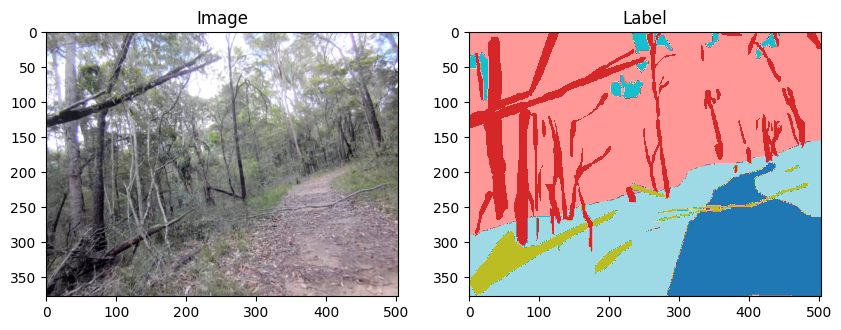

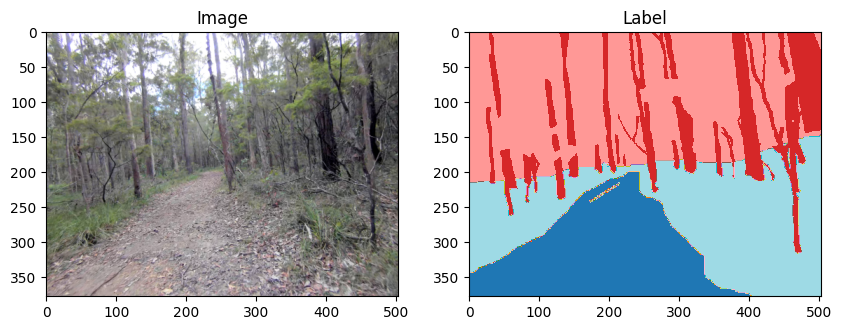

Data is prepared for PyTorch.


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [10]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
import segmentation_models_pytorch as smp
import pprint
import signal
#import sys
import pickle


# Directories
image_dir = './dataset/image'
label_dir = './dataset/indexLabel'

downscale_factor = 4  # This can be adjusted
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"CUDA: {torch.cuda.is_available()}")

# Load images and labels
def load_data(image_dir, label_dir):
    image_files = sorted([f for f in os.listdir(image_dir) if f.endswith('.png')])
    label_files = sorted([f for f in os.listdir(label_dir) if f.endswith('.png')])

    images = []
    labels = []
    
    for img_file, lbl_file in zip(image_files, label_files):
        # Load image and label
        img = cv2.imread(os.path.join(image_dir, img_file))
        lbl = cv2.imread(os.path.join(label_dir, lbl_file), cv2.IMREAD_GRAYSCALE)

        # Downscale image and label
        img = cv2.resize(img, (img.shape[1] // downscale_factor, img.shape[0] // downscale_factor), interpolation=cv2.INTER_AREA)
        lbl = cv2.resize(lbl, (lbl.shape[1] // downscale_factor, lbl.shape[0] // downscale_factor), interpolation=cv2.INTER_NEAREST)

        # Normalize image
        img = img.astype('float32') / 255.0
        
        # Append to lists
        images.append(img)
        labels.append(lbl)

    # Convert lists to arrays
    images = np.array(images)
    labels = np.array(labels)
    
    return images, labels

# Display some images and their corresponding labels
def display_samples(images, labels, num_samples=2):
    for i in range(num_samples):
        plt.figure(figsize=(10, 5))
        
        plt.subplot(1, 2, 1)
        plt.imshow(cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB))
        plt.title('Image')
        
        plt.subplot(1, 2, 2)
        plt.imshow(labels[i], cmap='tab20')
        plt.title('Label')
        
        plt.show()

# Load data
images, labels = load_data(image_dir, label_dir)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)



# Display some samples from training data
print("Displaying samples from training data...")
display_samples(X_train, y_train)

print("Data is prepared for PyTorch.")

# Create a custom Dataset
class CustomDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

# Define the U-Net model with Dropout layers
import torchvision.models.segmentation as models
class DeepLabV3Plus(nn.Module):
    def __init__(self, num_classes):
        super(DeepLabV3Plus, self).__init__()
        self.model = models.deeplabv3_resnet101(pretrained=True)
        self.model.classifier[4] = nn.Conv2d(256, num_classes, kernel_size=1)

    def forward(self, x):
        return self.model(x)['out']


# Dice Loss
def dice_loss(preds, labels, smooth=1e-6):
    preds = torch.softmax(preds, dim=1)
    labels = labels.long()  # Ensure labels are integers
    labels_one_hot = torch.nn.functional.one_hot(labels, num_classes=preds.shape[1]).permute(0, 3, 1, 2).float()
    intersection = (preds * labels_one_hot).sum(dim=(2, 3))
    union = preds.sum(dim=(2, 3)) + labels_one_hot.sum(dim=(2, 3))
    dice = (2. * intersection + smooth) / (union + smooth)
    return 1 - dice.mean()

# mIoU Loss
def miou_loss(preds, labels, smooth=1e-6):
    preds = torch.argmax(preds, dim=1)
    labels = labels.long()
    iou_list = []
    for cls in range(preds.shape[1]):
        pred_inds = preds == cls
        target_inds = labels == cls
        intersection = (pred_inds & target_inds).sum().float()
        union = (pred_inds | target_inds).sum().float()
        iou = (intersection + smooth) / (union + smooth)
        iou_list.append(iou)
    miou = torch.mean(torch.tensor(iou_list))
    return 1 - miou

# Combined Loss (Cross Entropy + Dice Loss + mIoU Loss)
class CombinedLoss(nn.Module):
    def __init__(self):
        super(CombinedLoss, self).__init__()
        self.ce_loss = nn.CrossEntropyLoss()
        self.dice_loss = smp.losses.DiceLoss(mode='multiclass')
        #self.focal_loss = smp.losses.FocalLoss(mode='multiclass')

    def forward(self, preds, labels):
        ce_loss = self.ce_loss(preds, labels)
        dice = self.dice_loss(preds, labels)
        #focal = self.focal_loss(preds, labels)
        #dice = dice_loss(preds, labels)
        miou = miou_loss(preds, labels)
        return 0.3*ce_loss + 0.3*dice + 0.4*miou #+focal

# IoU Metric
def iou_score(preds, labels, num_classes):
    preds = torch.argmax(preds, dim=1)
    iou_list = []
    for cls in range(num_classes):
        pred_inds = preds == cls
        target_inds = labels == cls
        intersection = (pred_inds & target_inds).sum().float()
        union = (pred_inds | target_inds).sum().float()
        if union == 0:
            iou_list.append(float('nan'))  # If there is no ground truth, do not include in average
        else:
            iou_list.append((intersection / union).item())
    return np.nanmean(iou_list)  # Return the mean IoU, ignoring NaN values

# Changed
# Get IoU by class
def iou_score_class(preds, labels, num_classes):
    preds = torch.argmax(preds, dim=1)
    iou_list = [[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[]]
    for clss in range(num_classes):
        pred_inds = preds == clss
        target_inds = labels == clss
        intersection = (pred_inds & target_inds).sum().float()
        union = (pred_inds | target_inds).sum().float()
        if union == 0:
            iou_list[clss].append(float('nan'))  # If there is no ground truth, do not include in average
        else:
            iou_list[clss].append((intersection / union).item())
    return iou_list  # Return the mean IoU, ignoring NaN values

# Accuracy Metric
def accuracy(preds, labels):
    preds = torch.argmax(preds, dim=1)
    correct = (preds == labels).float().sum()
    total = labels.numel()
    return correct / total

# Early Stopping
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0


# Define the model
model = DeepLabV3Plus(num_classes=19).to(device)
# Load the previously saved model weights
#model.load_state_dict(torch.load('/workspace/9517/best_train_model.pth'))

# Input shape (height, width, channels)
input_shape = (378, 504, 3)
num_classes = 19

criterion = CombinedLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0003, weight_decay=1e-5)

# Data transformations
transform = transforms.Compose([
    transforms.ToTensor(),
])
# Create DataLoaders
batch_size = 4  # Recommended batch size 
train_dataset = CustomDataset(X_train, y_train, transform=transform)
test_dataset = CustomDataset(X_test, y_test, transform=transform)

# Split the training data into training and validation sets (80% training, 20% validation)
X_train_split, X_val, y_train_split, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

train_dataset_split = CustomDataset(X_train_split, y_train_split, transform=transform)
val_dataset = CustomDataset(X_val, y_val, transform=transform)

train_loader_split = DataLoader(train_dataset_split, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=4, verbose=True)
num_epochs=300
patience=35
######CHANGE##########
best_train_loss = float('inf')
best_val_loss = float('inf')
# Training the model with validation and early stopping
def train_model(model, train_loader, val_loader, criterion, optimizer, best_train_loss, best_val_loss, num_epochs, patience, scheduler=None):
    early_stopping = EarlyStopping(patience=patience)
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device).long()  # Ensure labels are integers
            
            optimizer.zero_grad()
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * inputs.size(0)
        
        epoch_loss = running_loss / len(train_loader.dataset)
        
        # Validation step
        model.eval()
        val_loss = 0.0
        val_acc = 0.0
        val_iou = 0.0
        val_dice = 0.0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs = inputs.to(device)
                labels = labels.to(device).long()  # Ensure labels are integers
                
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)
                
                val_acc += accuracy(outputs, labels).item() * inputs.size(0)
                val_iou += iou_score(outputs, labels, num_classes) * inputs.size(0)
                val_dice += (1 - dice_loss(outputs, labels).item()) * inputs.size(0)
        
        val_loss /= len(val_loader.dataset)
        val_acc /= len(val_loader.dataset)
        val_iou /= len(val_loader.dataset)
        val_dice /= len(val_loader.dataset)
        
        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, Val mIoU: {val_iou:.4f}, Val Dice: {val_dice:.4f}')

        ######CHANGE##########
        best_train_model_path = 'best_train_model.pth'
        best_val_model_path = 'best_val_model.pth'
        if epoch_loss < best_train_loss:
            best_train_loss = epoch_loss
            torch.save(model.state_dict(), best_train_model_path)
            print(f'Saved best TRAIN model with loss: {best_train_loss:.4f} at epoch {epoch}')
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), best_val_model_path)
            print(f'Saved best VAL model with loss: {best_val_loss:.4f} at epoch {epoch}')

        if scheduler != None:
            scheduler.step(val_loss)
        
        early_stopping(val_loss)
        if early_stopping.early_stop:
            print("Early stopping")
            break

# Evaluate the model
# CHANGED
def evaluate_model(model, test_loader, criterion, num_classes):
    model.eval()
    test_loss = 0.0
    test_acc = 0.0
    test_iou = []
    test_dice = 0.0
    test_miou = 0.0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device).long()  # Ensure labels are integers
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * inputs.size(0)
            
            test_acc += accuracy(outputs, labels).item() * inputs.size(0)
            test_iou.append(iou_score_class(outputs, labels, num_classes))
            test_dice += (1 - dice_loss(outputs, labels).item()) * inputs.size(0)
            test_miou += iou_score(outputs, labels, num_classes) * inputs.size(0)
    
    test_loss /= len(test_loader.dataset)
    test_acc /= len(test_loader.dataset)
    test_dice /= len(test_loader.dataset)
    test_miou /= len(test_loader.dataset)
    iouResult = [0]*19
    iouCount = [0] *19
    for input in test_iou:
        for classIndex in range(len(input)):
            # iouResult[classIndex] += np.nansum(input[classIndex])
            # print(len(input[classIndex]))
            for element in input[classIndex]:
                if not np.isnan(element) and classIndex != 13:
                    if classIndex == 1:
                        classIndex = 6
                    if classIndex == 12:
                        classIndex = 16
                    iouResult[classIndex] += element
                    iouCount[classIndex] += 1
    for classIndex in range(len(iouResult)):
        if iouCount[classIndex] != 0:
            iouResult[classIndex] /= iouCount[classIndex]
    iouPrint = {
        "00. unlabeled":iouResult[0],
        "01. asphalt(Merged to 06)":iouResult[1],
        "02. dirt":iouResult[2],
        "03. mud":iouResult[3],
        "04. water":iouResult[4],
        "05. gravel":iouResult[5],
        "06. other-terrin":iouResult[6],
        "07. tree-trunk":iouResult[7],
        "08. tree-foliage":iouResult[8],
        "09. bush":iouResult[9],
        "10. fence":iouResult[10],
        "11. structure":iouResult[11],
        "12. pole(Merged to 16)":iouResult[12],
        "13. vehicle(Excluded)":iouResult[13],
        "14. rock":iouResult[14],
        "15. log":iouResult[15],
        "16. other-object":iouResult[16],
        "17. sky":iouResult[17],
        "18. grass":iouResult[18],
    }
    print(f'Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}, Test Dice: {test_dice:.4f}, mIoU: {test_miou:.4f}, Class IoU:')
    pprint.pprint(iouPrint)


def apply_colormap(array, colormap):
    colormap = plt.get_cmap(colormap)
    colored_array = colormap(array / array.max())
    colored_array = (colored_array[:, :, :3] * 255).astype(np.uint8)  # 转换为 0-255 的 RGB 图像
    return colored_array

# Post-process the output to get class labels
def predict_and_display(model, data_loader, num_samples=5):
    model.eval()
    samples = iter(data_loader)
    with torch.no_grad():
        for i in range(num_samples):
            inputs, labels = next(samples)
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            cv2.imwrite(f"{i}-1.png", np.transpose(inputs.cpu().numpy()[0], (1, 2, 0))) 
            cv2.imwrite(f"{i}-2.png", apply_colormap(torch.argmax(outputs[0], dim=0).cpu().numpy(), 'tab20')) 
            cv2.imwrite(f"{i}-3.png", apply_colormap(labels[0].cpu().numpy(), 'tab20')) 




In [11]:
# Changed
signal.signal(signal.SIGINT, lambda _,__ : evaluate_model(model, test_loader, criterion, num_classes))

# Train the model with validation
train_model(model, train_loader_split, val_loader, criterion, optimizer, best_train_loss, best_val_loss,num_epochs,patience,scheduler)


Epoch 1/300, Train Loss: 0.2656, Val Loss: 0.2090, Val Acc: 0.8388, Val mIoU: 0.4101, Val Dice: 0.1686
Saved best TRAIN model with loss: 0.2656 at epoch 0
Saved best VAL model with loss: 0.2090 at epoch 0
Epoch 2/300, Train Loss: 0.2062, Val Loss: 0.1999, Val Acc: 0.8422, Val mIoU: 0.4162, Val Dice: 0.1744
Saved best TRAIN model with loss: 0.2062 at epoch 1
Saved best VAL model with loss: 0.1999 at epoch 1
Epoch 3/300, Train Loss: 0.1907, Val Loss: 0.1889, Val Acc: 0.8502, Val mIoU: 0.4402, Val Dice: 0.1816
Saved best TRAIN model with loss: 0.1907 at epoch 2
Saved best VAL model with loss: 0.1889 at epoch 2
Epoch 4/300, Train Loss: 0.1852, Val Loss: 0.1845, Val Acc: 0.8509, Val mIoU: 0.4305, Val Dice: 0.1823
Saved best TRAIN model with loss: 0.1852 at epoch 3
Saved best VAL model with loss: 0.1845 at epoch 3
Epoch 5/300, Train Loss: 0.1777, Val Loss: 0.1844, Val Acc: 0.8470, Val mIoU: 0.4428, Val Dice: 0.1812
Saved best TRAIN model with loss: 0.1777 at epoch 4
Saved best VAL model with

In [12]:

# Evaluate the model
evaluate_model(model, test_loader, criterion, num_classes)


Test Loss: 0.2312, Test Acc: 0.8580, Test Dice: 0.1993, mIoU: 0.4772, Class IoU:
{'00. unlabeled': 0,
 '01. asphalt(Merged to 06)': 0,
 '02. dirt': 0.7263019938391071,
 '03. mud': 0.11884776008841784,
 '04. water': 0.24408571917394345,
 '05. gravel': 0.4126796384897226,
 '06. other-terrin': 0.18025249987840652,
 '07. tree-trunk': 0.5435429973913742,
 '08. tree-foliage': 0.839870564572446,
 '09. bush': 0.06601172320580291,
 '10. fence': 0.15781199074152744,
 '11. structure': 0.2685979631680407,
 '12. pole(Merged to 16)': 0,
 '13. vehicle(Excluded)': 0,
 '14. rock': 0.10694600507372716,
 '15. log': 0.21329102665078137,
 '16. other-object': 0.2909072335406216,
 '17. sky': 0.7190638442297239,
 '18. grass': 0.6247215730112952}


In [13]:
# Display predictions for some test samples
predict_and_display(model, test_loader)